In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import sys
import time
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./kaggle/input/cifar10-comp/train_labels.csv
./kaggle/input/cifar10-comp/train_images.npy
./kaggle/input/cifar10-comp/test_images.npy
./kaggle/input/cifar10-comp/sample_submission.csv


# CIFAR-10 .-. Yet another DenseNet implementation

After readeing the [DenseNet paper](https://arxiv.org/abs/1608.06993v5), I was -as impressionable as a beginner can be- surprised by its simple architecture and its powerful performance when compared agains other very well known image classification networks.<br>

I wanted to make my own implementation of DenseNet and see it working - just because I find pleasure in implementing different solutions by myself to understand them. At the end I hope that by making these exercises I get to learn something beyond the readings of a paper. This exercise is more about having a working implementatino of DenseNet and less about finding a solution for CIFAR-10. I have no doubts I will get a good score -like everybody else have already gotten- but really, this is more a playground to experiment with my implementation of the paper.<br>

So, this is my own implementation of DenseNet. I have created a github repository as well, which is found here.

I want to mention that I tried to write my implementation as loyal to the paper as my understanding of it allowed me. At the end I compared my implementation against [this other implementation](https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/densenet.py). I am glad to find out that some parts of my implementations were written basically identically, but I find my implementation in general (but especially of the construction of the DenseNet) to be more interesting as well as to follow in a better way the paper, allowing the user to decide whether to use and/or construct DenseNet-BC or just a regular DenseNet network (without compression factor and without bottleneck layers).

### Data preparation and augmentation after its loading 

In the following hidden cells, a dataset consisting of the images and its labels is being constructed.<br>
First a class that takes numpy arrays that encode images and their labels is defined.<br>
Next, the data is loaded into numpy arrays. For the images labels a numpy array is constructed with the 
corresponding index of the 'classes' list (also defined in the hidden cell).<br>
Once the images and its labels are loaded in numpy arrays, the cifar dataset is constructed by using the
defined CifarDataset class. For this, a transformation has also been defined to process the images. This transformation 
is passed to the CifarDataset instance created, so that when samples are taken from that dataset, the returned
images will be training-ready.<br>
At last, training and validation sub-sets are prepared out of the training images, together with data loaders, which will be providing batches of training and validation images to the training process.

In [2]:
# constants ....
batch_size = 64 # samples per batch
num_workers = 48 #number of subprocesses to use for data loading
valid_percentage = .20


# CifarDataset is a class that construct a dataset out of training images
# stored as numpy arrays and its corresponding training labels - also
# stored as numpy arrays
class CifarDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index] 
        y = self.target[index]
        if self.transform:
            x = self.transform(Image.fromarray(x.numpy()))
        
        return x, y
    
    def __len__(self):
        return len(self.data)
    
    
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# loading the images and training labels
test_images  = np.load('./kaggle/input/cifar10-comp/test_images.npy')
train_images = np.load('./kaggle/input/cifar10-comp/train_images.npy')
train_labels = pd.read_csv('./kaggle/input/cifar10-comp/train_labels.csv')
train_labels = pd.Series(train_labels['Category'])

# we need to correctly  transpose the numpy arrays, so
# they can be converted to PIL images later while they are being
# drawn from the data loaders
train_images = train_images.transpose([0,2,3,1])

train_int_labels = np.array([]) # numpy array where the training labels are going to be stored as integer value
for x in train_labels:
    train_int_labels = np.append(train_int_labels, [classes.index(x)])
    
    
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating the cifar dataset
x_train = CifarDataset(train_images, train_int_labels, transform=transform)

# training indices to be used for validation purposes
indices = list(range(len(x_train)))
# split the training dataset into a -real- training dataset and a validation set
np.random.shuffle(indices)
split = int(np.floor(len(x_train) * valid_percentage)) # we take 24 percent of the training dataset for validation
train_indices, valid_indices = indices[split:], indices[:split]

# define samplers - they sample/obtain batches from a list of indices.
# batches are built out of random sampled elements
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# prepare loaders
train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_images, batch_size=batch_size, num_workers=num_workers)

### Visualizing some images - after transformation

This section serves both to demonstrate the usage of the loaders as well as to make sure the transformations are performed to the images.<br>
A train loader iterator is here created to draw batches of images which have been processed by the 'transforms' transformations. Those images are converted to a numpy arrays so they can be plotted.

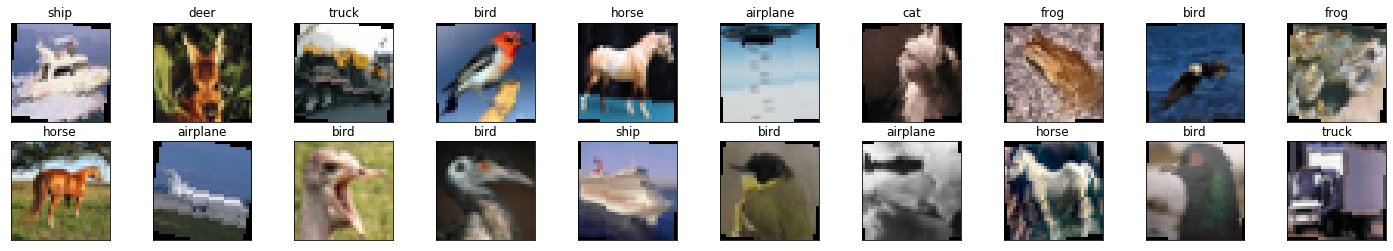

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def showImage(img):
    img = img / 2 + 0.5 # unnormalize the picture
    plt.imshow(np.transpose(img, (1,2,0))) # convert from Tensor image

    

# get a batch of training images
dataiterator = iter(train_loader)
images, labels = dataiterator.next()
images = images.numpy() # convert images to numpy for display

# plot the iamges of the batch
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    showImage(images[i])
    ax.set_title(classes[labels[i]])

The image (or displaying the image below) is really irrelevant for this exercise, but it is usefull to understand how convolutional networks "see" different pictures in different channels (i.e. feature maps) and how they can learn different patterns from each one of those channels.

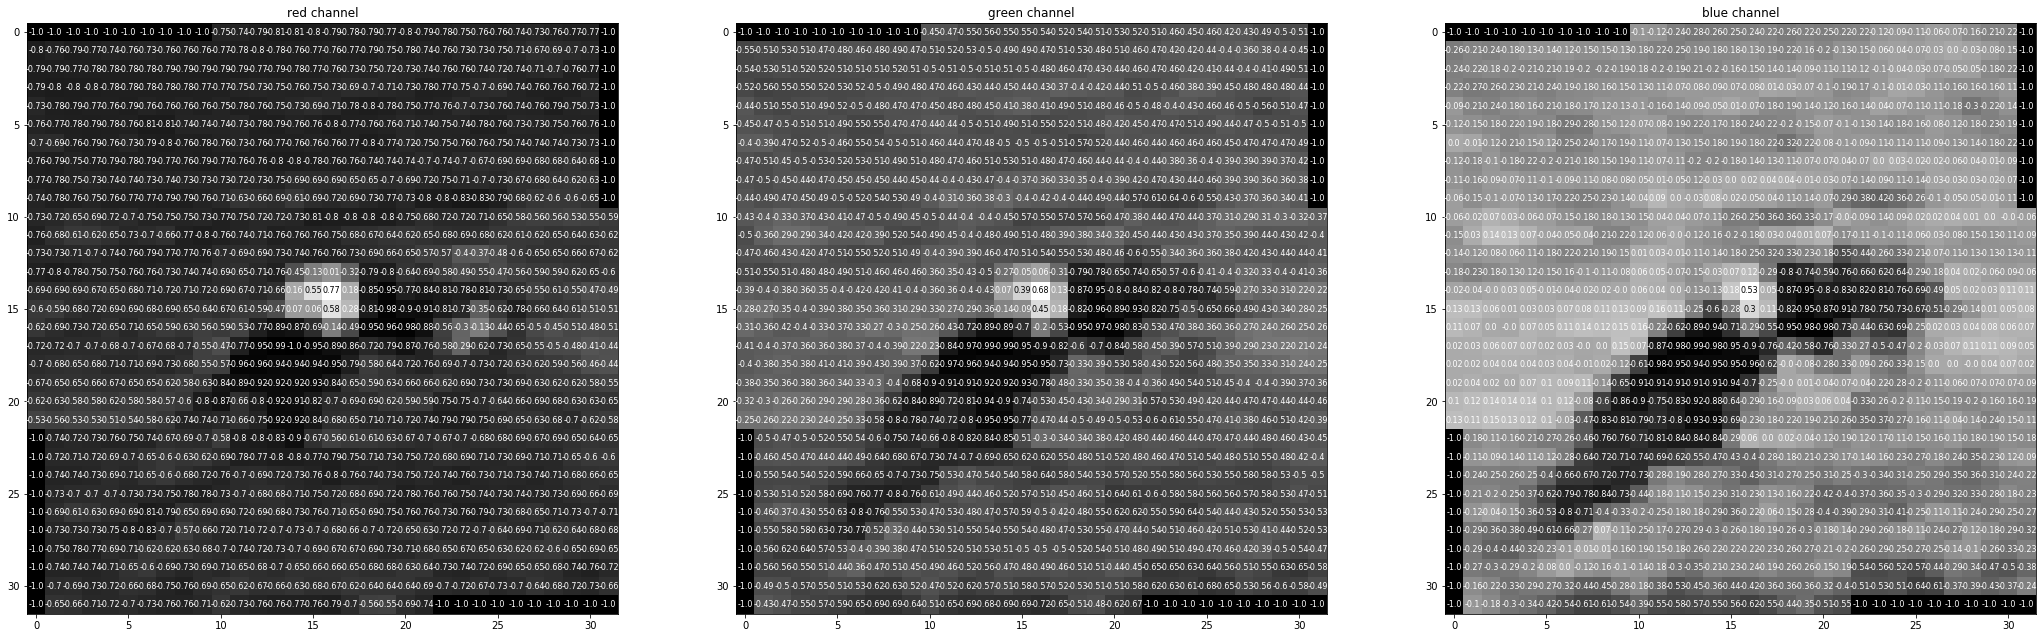

In [4]:
rgb_img = np.squeeze(images[8])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## My DenseNet implementation (DenseNet class)

### My DenseNet implementation.

In [5]:
class DenseNet(nn.Module):
    def __init__(self, nLayers, tlayer="Bottleneck", k=32, compression_factor=0.5, nClasses=100):
        super(DenseNet, self).__init__()
        
        # validate parameters...
        nLayers, layer, self.compression_factor = self.__Validate_params(nLayers, tlayer, compression_factor)

        # create the main sequentail module
        self.densenet = nn.Sequential()

        # Before entering the first dense block, a convolution with 16 (or twice the growth rate for DenseNet-BC)
        # ouput channels is performed on the input images.
        preprocess_outmaps = 2 * k if (layer is self.__Bottleneck and self.compression_factor < 1.) else 16
        self.densenet.add_module("preprocessInput", nn.Conv2d(3, preprocess_outmaps, kernel_size=3, stride=1, padding=1, padding_mode='zeros', bias=True))

        # create the dense blocks according to the size of the 'nLayers' list
        # I define - for clarity/readability reasons - a 'innerChanns' variable whose 
        # value is initialized to 'preprocess_outmaps'
        innerChanns = preprocess_outmaps
        
        for indx in range(len(nLayers) - 1): # we skip here the creation of the last dense block ....
                
            # build a dense block with the number of layers according
            # to the index 'indx' of the 'nLayers' list
            locals()['DenseBlock_{}'.format(indx)] = nn.Sequential()
            for f in range(nLayers[indx]):
                locals()['DenseBlock_{}'.format(indx)].add_module('H{}'.format(f), layer(innerChanns, k))
                innerChanns += k
            
            # add the just built dense block to the main sequential module (i.e. densenet)
            self.densenet.add_module('DN_block{}'.format(indx), locals()['DenseBlock_{}'.format(indx)])
            
            """ We use (...) transition layers between two contiguous dense blocsk """
            # add a transition layer right after a dense block - do not forget to explicitly add the compression factor argument!
            self.densenet.add_module('TransitionLayer_{}'.format(indx), self.__Transition_layer(innerChanns, self.compression_factor))
            # update the number of input feature maps of the next Dense Block
            innerChanns = int(innerChanns * self.compression_factor)

        # create and add the last dense block. This last dense block was previously left aside because
        # after this last dense block comes no transition layer. Instead a global average pooling
        # takes place together with a fully connected network performing a softmax classifier.
        locals()['DenseBlock_{}'.format(len(nLayers) - 1)] = nn.Sequential()
        for f in range( nLayers[len(nLayers) - 1] ):
            locals()['DenseBlock_{}'.format(len(nLayers) - 1)].add_module('H{}'.format(f), layer(innerChanns, k))
            innerChanns += k
        # add the just built dense block to the main sequential module (i.e. densenet)
        self.densenet.add_module('DN_block{}'.format(len(nLayers) - 1), locals()['DenseBlock_{}'.format(len(nLayers) - 1)])

        """ At the end of the last dense block, a global average pooling is performed
            and then a softmax classifier is attached. """
        # With adaptive pooling the output can be reduced to any feature map size,
        # although in practice it is often choosen size 1, in which case
        # it does the same thing as global pooling
        # - but first a batch and relu layer (I included this two layers after checking the implementation 
        # I refer to at the begining of this notebook. I checked the evaluation loss without these layer (first)
        # and with these layers (after) and it works best wtih them.
        preSoftmax_layer = nn.Sequential(
            nn.BatchNorm2d(innerChanns),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1)
        )
        self.densenet.add_module('preSoftmax_layer', preSoftmax_layer)
        
        # a linear transformation is used here as a Softmax layer. 
        self.fakeSoftmax = nn.Linear(innerChanns, nClasses, bias=True)

        # initialize all weights and biases
        self.densenet.apply(self.__InitW_uniCenter)
        self.fakeSoftmax.apply(self.__InitW_uniCenter)
        
        
    def forward(self, x):
        y = self.densenet(x)
        y = y.view(y.size()[0], -1)
        return self.fakeSoftmax(y)


    def __InitW_uniCenter(self, m):
        """ General rule for setting the weights in a neural network is to set
            them to be close to zero without being too small. A uniform gaussian
            distribution centered at zero is used towards this end. """
        classname = m.__class__.__name__
        # for every linear layer in a model ...
        if classname.find('Linear') != -1:
            # get the number of inputs
            n = m.in_features
            y = 1. / np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)


    """ Pooling layers. The concatenation operation used in 
        Eq. (2) is not viable when the size of feature-maps changes.
        However, an essential part of convolutional networks is
        down-sampling layers that change the size of feature-maps.
        To facilitate down-sampling in our architecture we divide 
        the network into multiple densely connected dense blocks;
        see Figure 2. We refer to layers between blocks as transition
        layers, which do convolution and pooling. The transition
        layers used in our experiments consist of a batch normalization
        layer and an 1 x 1 convolutional layer followed by a
        2 x 2 average pooling layer. """
    class __Transition_layer(nn.Module):
        def __init__(self, chann_in, compression_factor=1):
            # constructor of the class
            super().__init__()
            """ Compression. To further improve model compactness,
                we can reduce the number of feature-maps at transition
                layers. If a dense block contains m feature-maps, we let
                the following transition layer generate [θm] output feature-
                maps, where 0 < θ ≤ 1is referred to as the compression fac-
                tor.  When θ= 1, the number of feature-maps across transi-
                tion layers remains unchanged.  We refer the DenseNet with
                θ < 1 as DenseNet-C, and we set θ = 0.5 in our experiment.
                When both the bottleneck and transition layers with θ < 1
                are used, we refer to our model as DenseNet-BC. """
            chann_out = int(chann_in * compression_factor)
            self.__Transition_layer = nn.Sequential(
                nn.BatchNorm2d(chann_in),
                nn.Conv2d(
                    chann_in, chann_out, kernel_size=1, stride=1, padding=0, bias=True
                        ),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
            
            
        def forward(self,x):
            return self.__Transition_layer(x)


    """ Bottleneck layers. Although each layer only produces k
        output feature-maps, it typically has many more inputs. It
        has been noted in [37, 11] that a 1 x 1 convolution can be introduced
        as bottleneck layer before each 3 x 3 convolution
        to reduce the number of input feature-maps, and thus to
        improve computational efficiency. We find this design especially
        effective for DenseNet and we refer to our network
        with such a bottleneck layer, i.e., to the BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3)
        vresion of H_l, as DensNet-B. In our experiments, we let each 1x1
        convolution produce 4k feature-maps (where k = Growth rate). """
    class __Bottleneck(nn.Module):
        """ Bottleneck layer is an exclusive layer
            of DenseNet-B - a version of DenseNet. """
        def __init__(self, chann_in, growth_rate):
            # constructor of the class
            super().__init__()
            self.__Bottleneck = nn.Sequential(
                nn.BatchNorm2d(chann_in),
                nn.ReLU(inplace=True),
                nn.Conv2d(chann_in, 4 * growth_rate, kernel_size=1, stride=1, padding=0, bias=True),
                nn.BatchNorm2d(4 * growth_rate),
                nn.ReLU(inplace=True),
                nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1,
                        padding_mode='zeros', bias=True)
            )
            
            
        def forward(self, x):
            return torch.cat([x, self.__Bottleneck(x)], 1)


    """ Composite function.Motivated by [12], we define H_l(·)
        as  a  composite  function  of  three  consecutive  operations:
        batch normalization (BN) [14], followed by a rectified lin-
        ear unit (ReLU) [6] and a3×3convolution (Conv). """
    class __H_layer(nn.Module):
        """ Composite function. This layer is used always when
            DenseNet-B is not. """
        def __init__(self, chann_in, growth_rate):
            # constructor of the class
            super().__init__()
            self.h = nn.Sequential(
                nn.BatchNorm2d(chann_in),
                nn.ReLU(inplace=True),
                nn.Conv2d(chann_in, growth_rate, kernel_size=3, stride=1, padding=1,
                        padding_mode='zeros', bias=True)
            )
        
        def forward(self, x):
            return torch.cat([x, self.h(x)], 1)
        
        
    def __Validate_params(self, nLayers, tlayer, compression_factor):
        # validate the parameters given to the main class creator, to
        # ensure a minimum degree of sane functionality

        # check for the type of layer to be used....
        if tlayer == "Bottleneck" or tlayer is None:
            layer = DenseNet.__Bottleneck
            # save the compression factor value - needed to further build the network
            real_compression_factor = compression_factor
        elif tlayer == "H_layer":
            layer = DenseNet.__H_layer
            # save the compression factor value - needed to further build the network
            if compression_factor < 1:
                print("Compression factor smaller than 1.0 is exclusive of DenseNet BC.")
                print("Compression factor has been set to 1.0")
                real_compression_factor = 1.0
            else:
                real_compression_factor = compression_factor
        else:
            print("Layer type not supported in DenseNet.")
            print("Must be either 'Bottleneck' of 'H_layer'")
            print("For mor information, refer to the DenseNet paper:")
            print("     https://arxiv.org/abs/1608.06993v5")
            sys.exit(1)
            
        # check that nLayers is either of type int or list
        # if nLayer is of type list, check that it is not empty
        if isinstance(nLayers, int):
            nLayers = [nLayers]
        elif isinstance(nLayers, list) and 0 < len(nLayers):
            nLayers = nLayers
        else:
            print("nLayer must be an int or a list containing the")
            print("number of layers to be created per dense block.")
            print("If a list is given as argument, so many dense blocks")
            print("will be created as elements on the list.")
            sys.exit(1)
        
        return nLayers, layer, real_compression_factor

### Model training function

In [6]:
def TrainModel(model, criterion, optimizer, nEpochs, train_stats, bestModelName = None, lr_update_at_Epoch_perc=0.20, minLr_val_at_Epoch_perc=0.9,
               train_loader=train_loader, valid_loader=valid_loader):
    
    valid_loss_min = np.Inf # track chane in validation loss
    start_lr_update = True
    minimum_lr_val_reached = True
    
    initial_lr = optimizer.defaults['lr']
    target_lr = 0.001 # const value.
    start_lr_update_at_epoch = int(nEpochs * lr_update_at_Epoch_perc)        # start updating the learning rate at this percentage of the nEpochs
    epoch_with_last_lr_update = int(nEpochs * minLr_val_at_Epoch_perc)                  # epoch at which the last learning rate update will be done, reaching its minimum value
    minum_Lr_atEpoch_percentage = int(nEpochs * minLr_val_at_Epoch_perc)                # percentage of epochs at which the optimization will reach its minimum learning rate
    lr_update_step = (initial_lr - target_lr) / (minum_Lr_atEpoch_percentage - start_lr_update_at_epoch)
    
    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("Training on CUDA!")
        model.cuda()
    else:
        print("CUDA is not available.")
        
    parallel_model = nn.DataParallel(model)     # Encapsulate the model

    for epoch in range(1, nEpochs+1):
        
        if epoch >= start_lr_update_at_epoch and optimizer.defaults['lr'] > 0.001:
            if start_lr_update:
                print("Learning rate starts to be updated towards a value of 0.001")
                start_lr_update = False
                
            optimizer.defaults['lr'] -= lr_update_step
            if optimizer.defaults['lr'] < 0.001:
                optimizer.defaults['lr'] = 0.001 # in case the learning rate update went a bit below 0.001, we reset it to 0.001
                                                 # to avoid an extremly slow optimization                
                if minimum_lr_val_reached:
                    print("Minimum value of learning rate rached (i.e. 0.001)")
                    minimum_lr_val_reached = False

            
        # keep track of training and validation loss
        train_loss = 0
        valid_loss = 0
        train_accuracy = 0
        top3_train_accuracy = 0

        # start counting the elapsed time
        starting_timePoint = time.time()

        ## Training the model ##
        model.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass -> compute predicted outputs by passing inputs to the model
            output = parallel_model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.mean().backward()
            # finally, perform one optimization step (an update of the parameters towards the disminution of error direction)
            optimizer.step()
            # update training loss
            train_loss +=loss.item()*data.size(0)

            # calculating train top-1 accuracy
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # calculating train top-3 accuracy
            npTop3_classes = ps.topk(3, dim=1)[1].cpu().numpy()
            npTarget = target.cpu().numpy()
            top3_train_accuracy += np.mean([1 if npTarget[i] in npTop3_classes[i] else 0 for i in range(0, len(npTarget))])

        # check how much time has elapsed
        time_elapsed = time.time() - starting_timePoint


        validation_accuracy = 0
        top3_validation_accuracy = 0
        ## Validating the model ##
        model.eval()
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # forward pass -> compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)

            # calculating validation top-1 accuracy
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            validation_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # calculating validation top-3 accuracy
            npTop3_classes = ps.topk(3, dim=1)[1].cpu().numpy()
            npTarget = target.cpu().numpy()
            top3_validation_accuracy += np.mean([1 if npTarget[i] in npTop3_classes[i] else 0 for i in range(0, len(npTarget))])

        # calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tIn seconds: {:.4f}'.format(
            epoch, train_loss, valid_loss, time_elapsed))

        # save model if validation loss has decreased!
        if valid_loss <= valid_loss_min:
            print("Validation loss decreased ({:.6f} ---> {:.6f}). Saving model.".format(valid_loss_min,
                                                                                        valid_loss,))
            if bestModelName is None:
                torch.save(model.state_dict(), 'bestModelTrained.pt')
            else:
                torch.save(model.state_dict(), '{}.pt'.format(bestModelName))
                
            valid_loss_min = valid_loss

        train_stats = train_stats.append({
            'Epoch' : epoch,
            'Time per epoch' : time_elapsed,
            'Avg time per step' : time_elapsed / len(train_loader.sampler),
            'Train loss' : train_loss,
            'Train accuracy' : train_accuracy / len(train_loader),
            'Train top-3 accuracy' : top3_train_accuracy / len(train_loader),
            'Validation loss' : valid_loss,
            'Validation accuracy' : validation_accuracy / len(valid_loader),
            'Validation top-3 accuracy' : top3_validation_accuracy / len(valid_loader)
        }, ignore_index=True)
        
    return train_stats

## Training a DenseNet-BC network

We must now build an instance of this DenseNet-BC implementation, specify a loss function and an optimizer to then train our network.

In [7]:
modDN_bc = DenseNet([6,12,24,16], tlayer="Bottleneck", k=32, nClasses=10)
nEpochs = 50
# as loss function cross entropy loss will be used
crit = nn.CrossEntropyLoss()
# and the optimizer ...
optimizer = optim.SGD(modDN_bc.parameters(), lr=0.01)

# we are collect some characteristic data from the training process
# to check some statistics
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step',
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy',
                                      'Validation loss', 'Validation accuracy', 'Validation top-3 accuracy']
                          )

# train the model
train_stats = TrainModel(modDN_bc, crit, optimizer, nEpochs, train_stats, bestModelName='best_modDN_bc_SGD_trained', lr_update_at_Epoch_perc=0.2, minLr_val_at_Epoch_perc=0.4)

Training on CUDA!
Epoch: 1 	Training Loss: 1.853287 	Validation Loss: 1.388778 	In seconds: 121.6515
Validation loss decreased (inf ---> 1.388778). Saving model.
Epoch: 2 	Training Loss: 1.314335 	Validation Loss: 1.171810 	In seconds: 116.5119
Validation loss decreased (1.388778 ---> 1.171810). Saving model.
Epoch: 3 	Training Loss: 1.088275 	Validation Loss: 0.967873 	In seconds: 115.3893
Validation loss decreased (1.171810 ---> 0.967873). Saving model.
Epoch: 4 	Training Loss: 0.922361 	Validation Loss: 0.957079 	In seconds: 115.9341
Validation loss decreased (0.967873 ---> 0.957079). Saving model.
Epoch: 5 	Training Loss: 0.801035 	Validation Loss: 0.829873 	In seconds: 115.2104
Validation loss decreased (0.957079 ---> 0.829873). Saving model.
Epoch: 6 	Training Loss: 0.703262 	Validation Loss: 0.687940 	In seconds: 117.6046
Validation loss decreased (0.829873 ---> 0.687940). Saving model.
Epoch: 7 	Training Loss: 0.635961 	Validation Loss: 0.709622 	In seconds: 117.2929
Epoch: 8 	

### Training & Validation losses and accuracy development over the number of epochs - DenseNet-BC

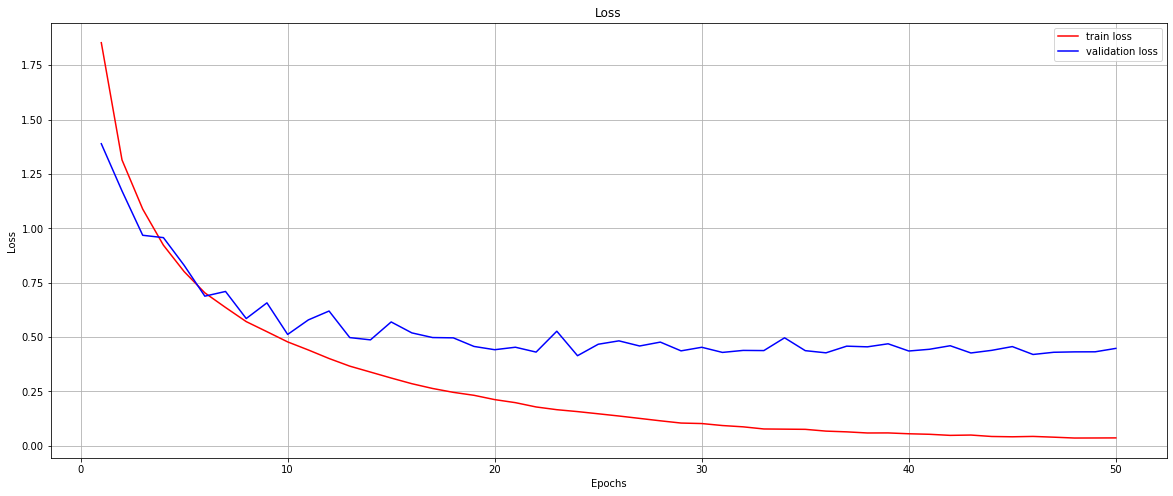

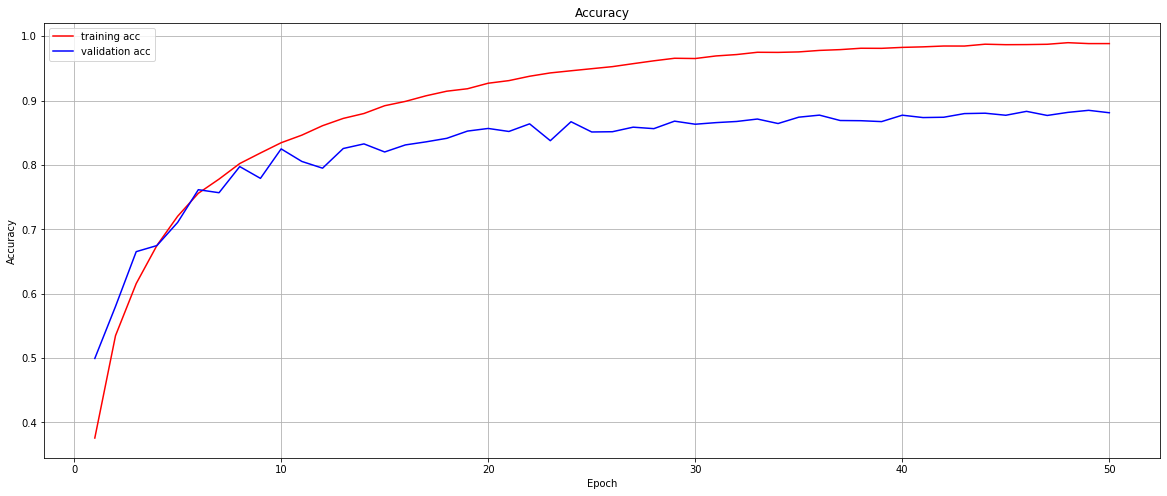

In [18]:
# plot the train and validation losses
fig1 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats['Epoch'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-r', label='train loss')
ax.plot(x, train_stats['Validation loss'].values, '-b', label='validation loss')
plt.legend()
plt.grid()


# plot the train and validation accuracies
fig2 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

x = range(1, len(train_stats['Epoch'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-r', label='training acc')
ax.plot(x, train_stats['Validation accuracy'].values, '-b', label='validation acc')
plt.legend()
plt.grid()

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [15]:
#modDN_bc_light = DenseNet([12,24,16], tlayer="Bottleneck", k=32, nClasses=10) minimum ~.36
modDN_bc_light = DenseNet([12,18,16], tlayer="Bottleneck", k=32, nClasses=10)
nEpochs = 50
# as loss function cross entropy loss will be used
crit = nn.CrossEntropyLoss()
# and the optimizer ...
optimizer = optim.SGD(modDN_bc_light.parameters(), lr=0.01)

# we are collect some characteristic data from the training process
# to check some statistics
train_stats_light = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step',
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy',
                                      'Validation loss', 'Validation accuracy', 'Validation top-3 accuracy']
                          )

# train the model
train_stats_light = TrainModel(modDN_bc_light, crit, optimizer, nEpochs, train_stats_light, bestModelName='best_modDN_bc_light_SGD_trained', lr_update_at_Epoch_perc=0.2, minLr_val_at_Epoch_perc=0.4)

Training on CUDA!
Epoch: 1 	Training Loss: 2.197173 	Validation Loss: 1.743161 	In seconds: 120.7620
Validation loss decreased (inf ---> 1.743161). Saving model.
Epoch: 2 	Training Loss: 1.495789 	Validation Loss: 1.285122 	In seconds: 122.1266
Validation loss decreased (1.743161 ---> 1.285122). Saving model.
Epoch: 3 	Training Loss: 1.265030 	Validation Loss: 1.214545 	In seconds: 122.3179
Validation loss decreased (1.285122 ---> 1.214545). Saving model.
Epoch: 4 	Training Loss: 1.088819 	Validation Loss: 0.953638 	In seconds: 123.4834
Validation loss decreased (1.214545 ---> 0.953638). Saving model.
Epoch: 5 	Training Loss: 0.957833 	Validation Loss: 1.466116 	In seconds: 122.2469
Epoch: 6 	Training Loss: 0.857889 	Validation Loss: 0.822048 	In seconds: 122.0764
Validation loss decreased (0.953638 ---> 0.822048). Saving model.
Epoch: 7 	Training Loss: 0.772045 	Validation Loss: 0.774493 	In seconds: 122.3703
Validation loss decreased (0.822048 ---> 0.774493). Saving model.
Epoch: 8 	

### Training & Validation losses and accuracy development over the number of epochs - DenseNet-BC-Light

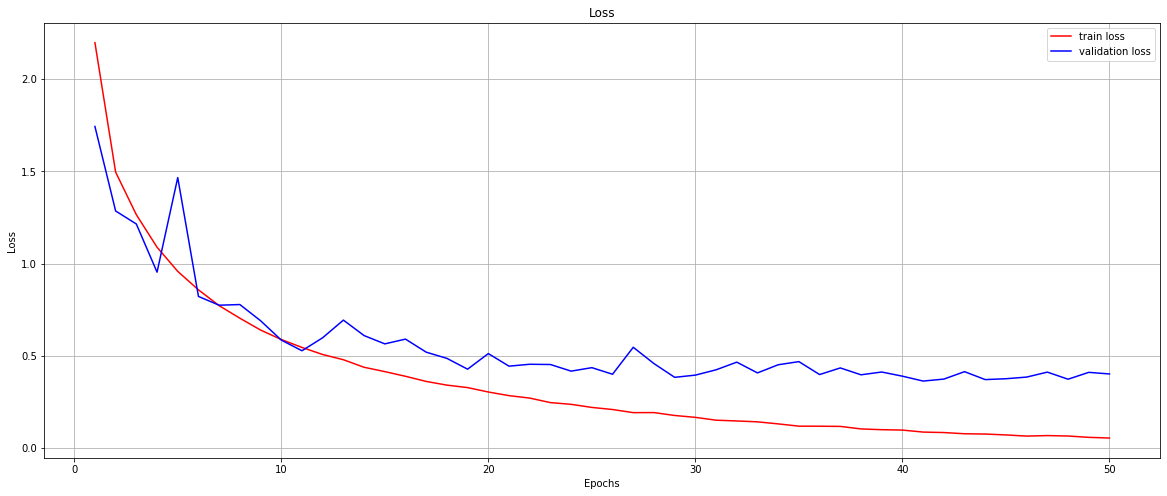

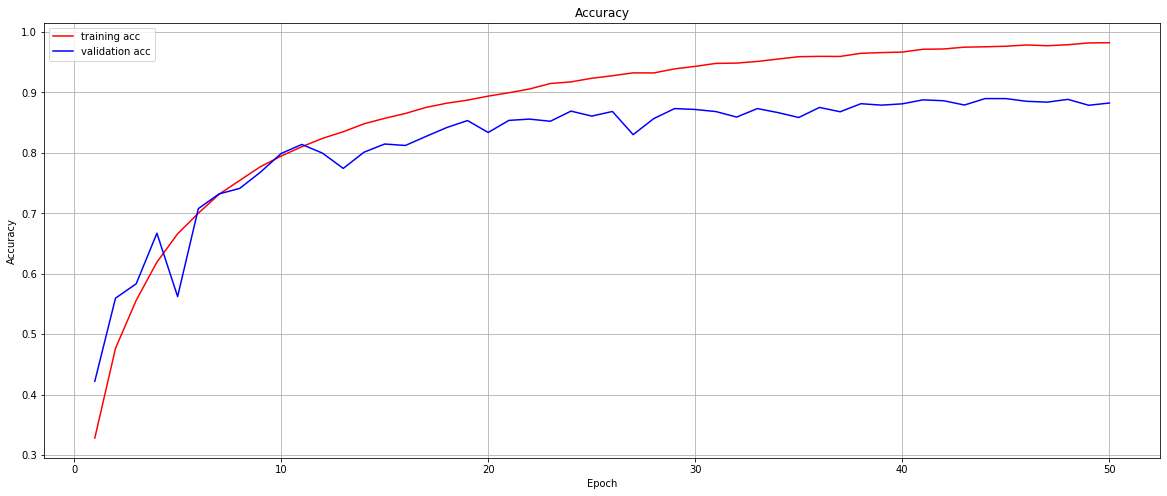

In [17]:
# plot the train and validation losses
fig1 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats_light['Epoch'].values) + 1)
ax.plot(x, train_stats_light['Train loss'].values, '-r', label='train loss')
ax.plot(x, train_stats_light['Validation loss'].values, '-b', label='validation loss')
plt.legend()
plt.grid()


# plot the train and validation accuracies
fig2 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

x = range(1, len(train_stats_light['Epoch'].values) + 1)
ax.plot(x, train_stats_light['Train accuracy'].values, '-r', label='training acc')
ax.plot(x, train_stats_light['Validation accuracy'].values, '-b', label='validation acc')
plt.legend()
plt.grid()

## Training a DenseNet network (not BC)

We must now build an instance of this DenseNet (not BC) implementation, specify a loss function and an optimizer to then train our network.

In [11]:
modDN_notBC = DenseNet([6,12,24,16], tlayer="H_layer", k=16, nClasses=10)
nEpochs = 50
# as loss function cross entropy loss will be used
crit = nn.CrossEntropyLoss()
# and the optimizer ...
optimizer = optim.SGD(modDN_notBC.parameters(), lr=0.01)

# we are collect some characteristic data from the training process
# to check some statistics
train_stats_notBC = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step',
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy',
                                      'Validation loss', 'Validation accuracy', 'Validation top-3 accuracy']
                          ) 

train_stats_notBC = TrainModel(modDN_notBC, crit, optimizer, nEpochs, train_stats_notBC, bestModelName='best_modDN_notBC_SGD_trained', lr_update_at_Epoch_perc=0.2, minLr_val_at_Epoch_perc=0.4)


Compression factor smaller than 1.0 is exclusive of DenseNet BC.
Compression factor has been set to 1.0
Training on CUDA!
Epoch: 1 	Training Loss: 1.610844 	Validation Loss: 1.394194 	In seconds: 71.2578
Validation loss decreased (inf ---> 1.394194). Saving model.
Epoch: 2 	Training Loss: 1.168899 	Validation Loss: 1.357943 	In seconds: 71.2130
Validation loss decreased (1.394194 ---> 1.357943). Saving model.
Epoch: 3 	Training Loss: 0.962147 	Validation Loss: 0.898751 	In seconds: 71.7514
Validation loss decreased (1.357943 ---> 0.898751). Saving model.
Epoch: 4 	Training Loss: 0.822162 	Validation Loss: 0.893705 	In seconds: 71.5746
Validation loss decreased (0.898751 ---> 0.893705). Saving model.
Epoch: 5 	Training Loss: 0.726315 	Validation Loss: 0.730230 	In seconds: 71.2396
Validation loss decreased (0.893705 ---> 0.730230). Saving model.
Epoch: 6 	Training Loss: 0.643906 	Validation Loss: 0.770110 	In seconds: 71.4836
Epoch: 7 	Training Loss: 0.597498 	Validation Loss: 0.610916 

### Training & Validation losses and accuracy development over the number of epochs - DenseNet (not BC)

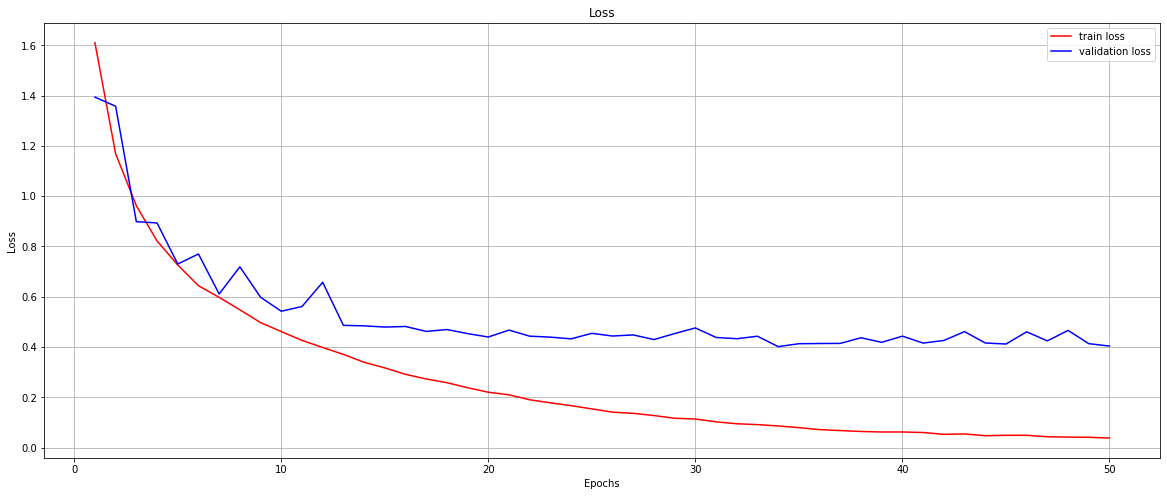

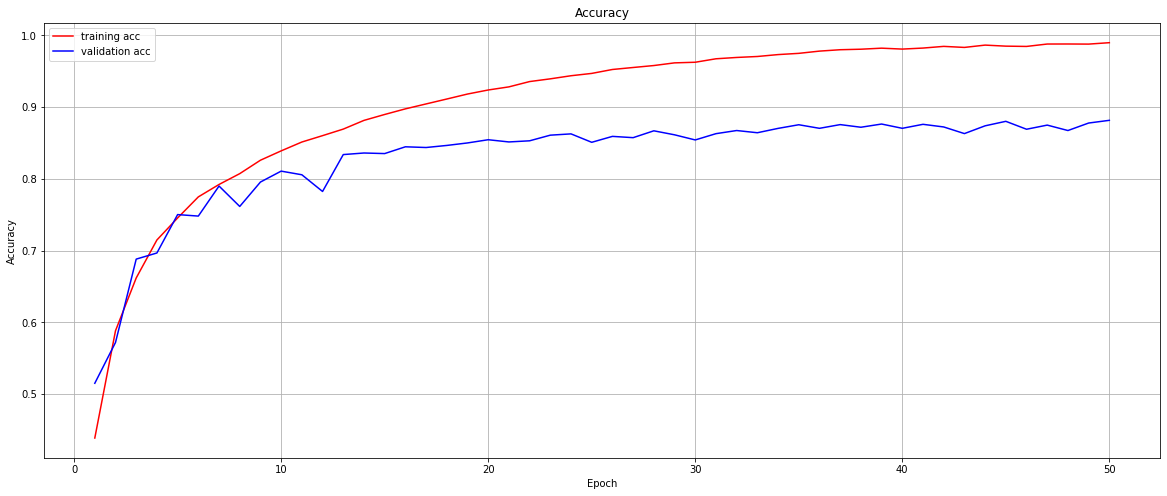

In [12]:
# plot the train and validation losses
fig1 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats_notBC['Epoch'].values) + 1)
ax.plot(x, train_stats_notBC['Train loss'].values, '-r', label='train loss')
ax.plot(x, train_stats_notBC['Validation loss'].values, '-b', label='validation loss')
plt.legend()
plt.grid()


# plot the train and validation accuracies
fig2 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

x = range(1, len(train_stats_notBC['Epoch'].values) + 1)
ax.plot(x, train_stats_notBC['Train accuracy'].values, '-r', label='training acc')
ax.plot(x, train_stats_notBC['Validation accuracy'].values, '-b', label='validation acc')
plt.legend()
plt.grid()

In [9]:
modDN_notBC_sec = DenseNet([6,12,24,36,4], tlayer="H_layer", k=48, nClasses=10)
nEpochs = 50
# as loss function cross entropy loss will be used
crit = nn.CrossEntropyLoss()
# and the optimizer ...
optimizer = optim.SGD(modDN_notBC_sec.parameters(), lr=0.01)

# we are collect some characteristic data from the training process
# to check some statistics
train_stats_notBC_sec = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step',
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy',
                                      'Validation loss', 'Validation accuracy', 'Validation top-3 accuracy']
                          ) 

train_stats_notBC_sec = TrainModel(modDN_notBC_sec, crit, optimizer, nEpochs, train_stats_notBC_sec, bestModelName='best_modDN_notBC_SGD_trained_sec', lr_update_at_Epoch_perc=0.2, minLr_val_at_Epoch_perc=0.4)

Compression factor smaller than 1.0 is exclusive of DenseNet BC.
Compression factor has been set to 1.0
Training on CUDA!
Epoch: 1 	Training Loss: 1.878863 	Validation Loss: 2.000076 	In seconds: 225.5989
Validation loss decreased (inf ---> 2.000076). Saving model.
Epoch: 2 	Training Loss: 1.254731 	Validation Loss: 1.573606 	In seconds: 225.6207
Validation loss decreased (2.000076 ---> 1.573606). Saving model.
Epoch: 3 	Training Loss: 1.008745 	Validation Loss: 0.791763 	In seconds: 225.5661
Validation loss decreased (1.573606 ---> 0.791763). Saving model.
Epoch: 4 	Training Loss: 0.840900 	Validation Loss: 0.669230 	In seconds: 225.5525
Validation loss decreased (0.791763 ---> 0.669230). Saving model.
Epoch: 5 	Training Loss: 0.727925 	Validation Loss: 0.737484 	In seconds: 225.5964
Epoch: 6 	Training Loss: 0.653737 	Validation Loss: 0.635857 	In seconds: 225.7403
Validation loss decreased (0.669230 ---> 0.635857). Saving model.
Epoch: 7 	Training Loss: 0.581524 	Validation Loss: 0.5

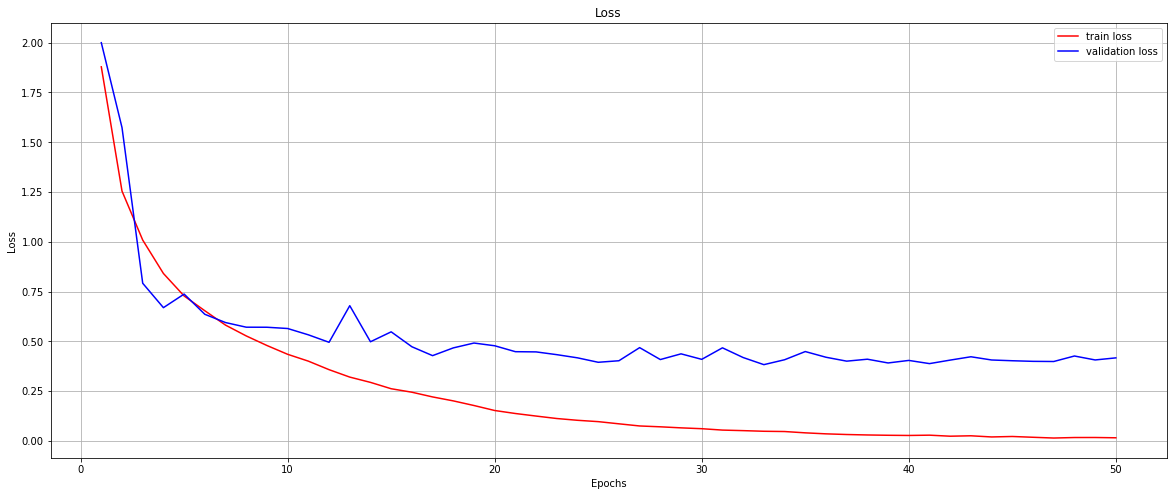

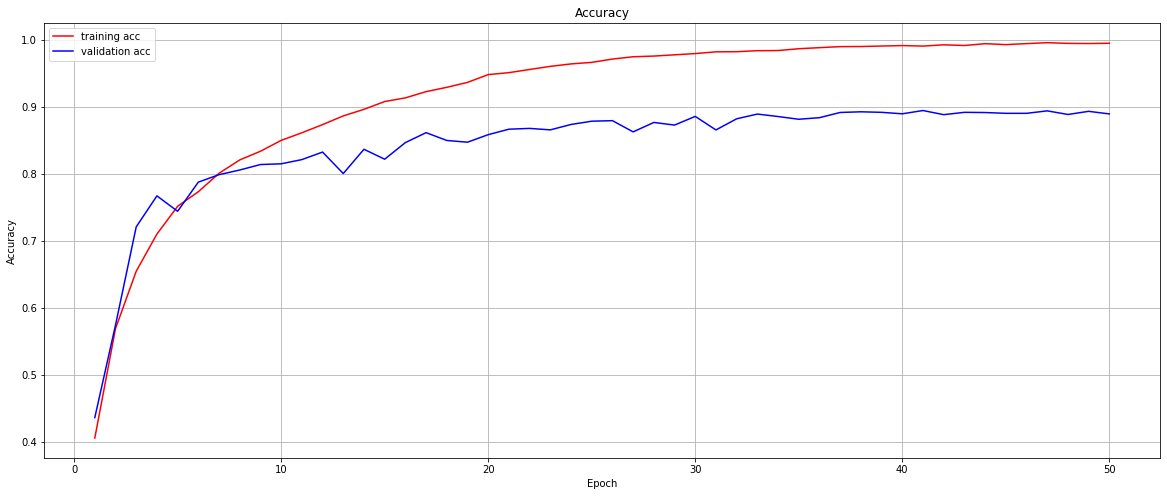

In [12]:
# plot the train and validation losses
fig1 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats_notBC_sec['Epoch'].values) + 1)
ax.plot(x, train_stats_notBC_sec['Train loss'].values, '-r', label='train loss')
ax.plot(x, train_stats_notBC_sec['Validation loss'].values, '-b', label='validation loss')
plt.legend()
plt.grid()


# plot the train and validation accuracies
fig2 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

x = range(1, len(train_stats_notBC_sec['Epoch'].values) + 1)
ax.plot(x, train_stats_notBC_sec['Train accuracy'].values, '-r', label='training acc')
ax.plot(x, train_stats_notBC_sec['Validation accuracy'].values, '-b', label='validation acc')
plt.legend()
plt.grid()